# Preprocessing the Yelp Reviews Dataset

### Importing libraries

In [ ]:
import re

import contractions
import matplotlib.pyplot as plt
import nltk
import pandas as pd
from bs4 import BeautifulSoup
from emot.core import emot
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
from tqdm import tqdm

from data.slangs import slangs_dict

emot_obj = emot()
tqdm.pandas()
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("omw-1.4")

### Constants

In [ ]:
file_path = "data/reviews_sample.csv"
processed_file_path = "data/reviews_sample_processed.csv"

## Simplifying the dataset

In [122]:
df = pd.read_csv(file_path)

Cause we are going to use this dataset for sentiment analysis, we can simplify the dataset by removing some columns and converting the `stars` column to binary labels.

In [123]:
df["label"] = df["stars"].apply(lambda x: "positive" if x >= 4 else "negative")
df["label"] = df["label"].astype("category")

Dropping the unnecessary columns, we keep only the `text` and `label` columns.

In [124]:
df = df[["text", "label"]]

## Text Cleaning

### Functions

In [125]:
def expressive_lengthening(text):
    return re.sub(r"(.)\1{2,}", r"\1", text)


def replace_emojis_and_emoticons(text):
    result_emoji = emot_obj.emoji(text)
    result_emoticon = emot_obj.emoticons(text)

    if result_emoji["flag"]:
        for symbol, meaning in zip(result_emoji["value"], result_emoji["mean"]):
            readable = meaning.replace(":", "").replace("_", " ")
            text = text.replace(symbol, readable)

    if result_emoticon["flag"]:
        for symbol, meaning in zip(result_emoticon["value"], result_emoticon["mean"]):
            readable = meaning.lower().replace(" ", "_")
            text = text.replace(symbol, readable)

    return text


def remove_html_markups(text):
    return BeautifulSoup(text, "html.parser").get_text()


def handle_slangs(tokens):
    return [slangs_dict.get(token.lower(), token) for token in tokens]


def remove_stopwords(tokens):
    stop_words = set(stopwords.words("english"))
    return [w for w in tokens if w.lower() not in stop_words]


def stem_tokens(tokens):
    stemmer = PorterStemmer()
    return [stemmer.stem(w) for w in tokens]


def lemmatize_tokens(tokens):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(w) for w in tokens]

In [126]:
def preprocess_text(text):
    text = expressive_lengthening(text)
    text = replace_emojis_and_emoticons(text)
    text = remove_html_markups(text)
    text = contractions.fix(text)

    tokens = word_tokenize(text)
    tokens = handle_slangs(tokens)
    tokens = remove_stopwords(tokens)
    tokens = stem_tokens(tokens)
    tokens = lemmatize_tokens(tokens)
    return " ".join(tokens)

### Applying the processed text

In [127]:
df["processed_text"] = df["text"].progress_apply(preprocess_text)

100%|██████████| 69903/69903 [02:17<00:00, 506.58it/s]


### Checking differences

In [129]:
df[df["text"] != df["processed_text"]].head(10)

,text,label,processed_text
0,Went for lunch and found that my burger was me...,negative,went lunch found burger whatev . obviou focu b...
1,I needed a new tires for my wife's car. They h...,positive,need new tire wife 's car . special order next...
2,Jim Woltman who works at Goleta Honda is 5 sta...,positive,jim woltman work goleta honda 5 star ! ! knowl...
3,Been here a few times to get some shrimp. The...,positive,time get shrimp . got nice select differ fish ...
4,This is one fantastic place to eat whether you...,positive,one fantast place eat whether hungri need good...
5,Dirt cheap happy hour specials. Half priced d...,negative,dirt cheap happi hour special . half price dri...
6,"Unbelievably poor customer ""service"". Beyond ...",negative,unbeliev poor custom `` servic '' . beyond bad...
7,I walked in the door and was greeted with a we...,positive,walk door greet welcom smile . offer help find...
8,Nothing beats pizza and beer in my book. This ...,positive,"noth beat pizza beer book . place nail , eye t..."
9,Philly cheese steak (loaded) was phenomenal. ...,positive,philli chees steak ( load ) phenomen . good se...


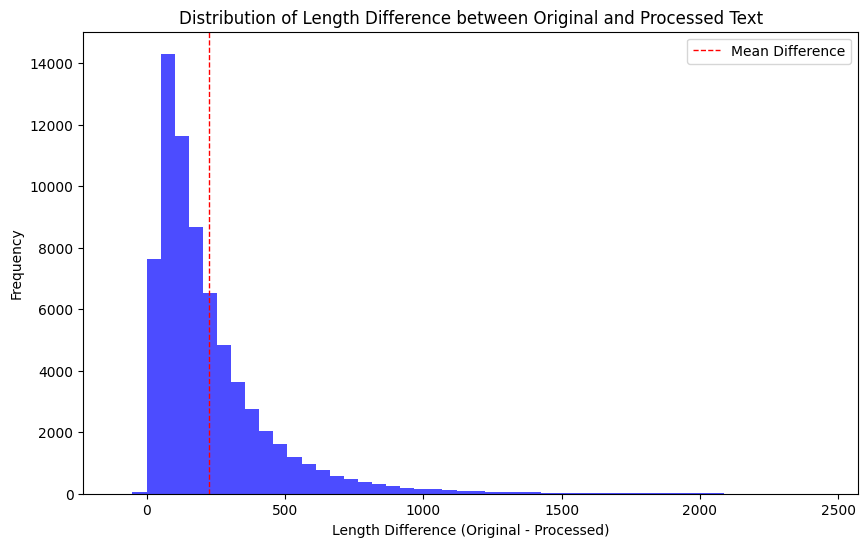

In [130]:
df["diff_len"] = df["text"].apply(len) - df["processed_text"].apply(len)
plt.figure(figsize=(10, 6))
plt.hist(df["diff_len"], bins=50, color="blue", alpha=0.7)
plt.title("Distribution of Length Difference between Original and Processed Text")
plt.xlabel("Length Difference (Original - Processed)")
plt.ylabel("Frequency")
plt.axvline(
    df["diff_len"].mean(),
    color="red",
    linestyle="dashed",
    linewidth=1,
    label="Mean Difference",
)
plt.legend()
plt.show()

### Saving the processed dataset

In [131]:
df["text"] = df["processed_text"]
df = df[["text", "label"]]
df.to_csv(processed_file_path, index=False)